In [ ]:
reset

In [1]:
# IMPORT LIBRARIES AND EIS DATA FILE
import csv, glob, os, sys, numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import timeit
from scipy import optimize
from numpy import NaN, Inf, arange, isscalar, asarray, array
from timeit import default_timer as timer
plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15 #make size of axis tick labels larger


bodefile = '2017-10-27 pdse2 h2o steps bode list.csv' #Bode filename
#################################################################
rawbodedata = pd.read_csv(bodefile, skiprows = 16, skip_blank_lines=True,
                       error_bad_lines=False, warn_bad_lines=False, sep=',') #read in file

bodedata = rawbodedata.apply(pd.to_numeric, errors='coerce').dropna() #str to flt, coerce to NaN, drop NaN
print(bodedata)

#convert data columns to numpy arrays
pointnum = np.array(bodedata['Number']).astype(float)
freq = np.array(bodedata['Frequency/Hz']).astype(float)
ztot = np.array(bodedata['Impedance/Ohm']).astype(float)
phasedeg = np.array(bodedata['Phase/deg']).astype(float)

       Number  Frequency/Hz  Impedance/Ohm  Phase/deg
0         1.0   8000000.000        41.0600      89.39
1         2.0   7699600.000        30.7490      87.51
2         3.0   7410500.000        23.0960      84.44
3         4.0   7132200.000        13.7140     100.82
4         5.0   6864400.000        10.4010      95.52
5         6.0   6606600.000         2.6121      48.37
6         7.0   6358500.000         7.6945     -70.94
7         8.0   6119800.000        12.0300     -80.43
8         9.0   5890000.000        12.5470     -58.56
9        10.0   5668800.000        16.2850     -79.29
10       11.0   5455900.000        23.5760     -94.27
11       12.0   5251100.000        32.6080     -99.39
12       13.0   5053900.000        40.4800     -98.81
13       14.0   4864100.000        47.9410     -96.71
14       15.0   4681400.000        55.7460     -95.07
15       16.0   4505700.000        63.8010     -93.81
16       17.0   4336500.000        70.9320     -95.16
17       18.0   4173600.000 

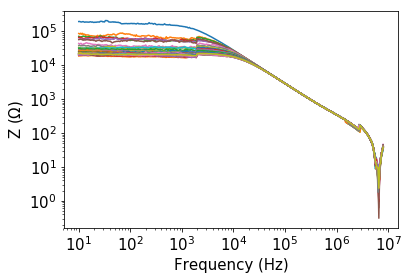

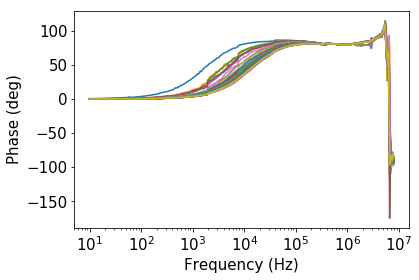

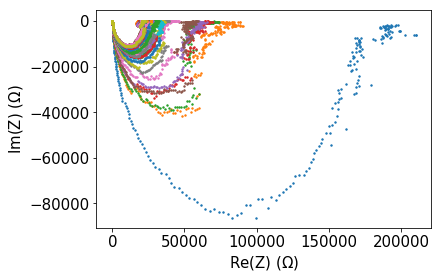

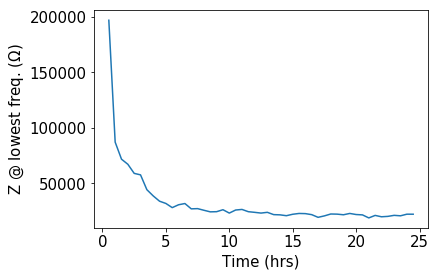

In [12]:
pointnum = np.unique(pointnum) #retain only one array of point numbers

freq = freq[0:len(pointnum)] #retain only one array of frequencies
#freq = np.flipud(freq) #(comment or uncomment this as needed) to flip frquency values 

ztot = ztot.reshape(-1, len(pointnum)) #reshape z array to separate spectra
phasedeg = phasedeg.reshape(-1, len(pointnum)) #reshape phase array to separate spectra
omega = 2*np.pi*freq #define angular frequency 
spectranum = len(ztot) #number of spectra present

delay = 30 # delay in minutes between spectra measurements #########################################
time = np.arange(spectranum)*delay + delay # establish time variable based on delay

for i in ztot: plt.loglog(freq,i) #plot Bode Z data
plt.xlabel('Frequency (Hz)', fontsize=15); plt.ylabel('Z ($\Omega$)', fontsize=15)
plt.show()

for i in phasedeg: plt.semilogx(freq,-i) #plot Bode phase data
plt.xlabel('Frequency (Hz)', fontsize=15); plt.ylabel('Phase (deg)', fontsize=15)
plt.show()

### calculate Re(Z) and Im(Z) using phase information ###############################################
phase = np.divide(np.multiply(np.pi,phasedeg),180)
rez = np.multiply(ztot, np.cos(phase))
imz = np.multiply(ztot, np.sin(phase))

for i in range(len(rez)): plt.scatter(rez[i],imz[i], s=2) #create Nyquist plots 
plt.xlabel('Re(Z) ($\Omega$)', fontsize=15); plt.ylabel('Im(Z) ($\Omega$)', fontsize=15)
plt.show()

lowfreqz = ztot[:,-1] # get z values at lowest frequencies measured ##################################
plt.plot(time/60, lowfreqz)
plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('Z @ lowest freq. ($\Omega$)', fontsize=15)
plt.show()


# Estimate parameters from Randles circuit: 1 series R, 1 c.t. R in parallel with 1 d.l. C
# get series resistance estimate (min value of Re(Z) in each spectrum) ##############################
rsguess = rez[:,0]

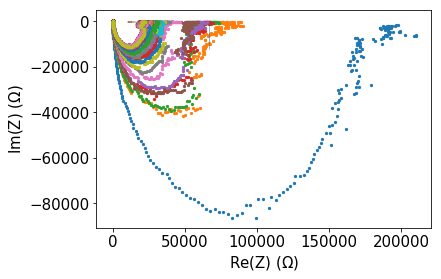

' \n#calculate r^2 value for fit:\nresiduals_ad = yad - linearfit(plinad, *popt) #residuals from fit\nr2_ad = 1 - (np.sum(residuals_ad**2) / np.sum((yad-np.mean(yad))**2)) #r^2 value\n    \n#perform calculations for analyzing BET data\nm = popt[0]; b = popt[1] #get slope and y-intercent of each linear fit'

In [13]:
# modelling of impedance spectra
from scipy.optimize import curve_fit

def quadfit(x, a, b, c):  # define variables in each function
    return a*x**2 + b*x + c 

def reZrandles(omega, c, r, rs):
    return rs +  r/(1+(omega*c*r)**2) 

def imZrandles(omega, c, r):
    return -omega*c*r**2/(1+(omega*c*r)**2)

cguess = 1e-6 #guess capacitance value
rguess = 1e6 #guess for resistance value

for i in range(len(rez)):
    #plt.scatter(freq, rez[i], s=5) #plot raw data points
    #plt.scatter(rez[i], imz[i], s=5) #plot raw data points
    
    popt, pcov = curve_fit(reZrandles, freq, rez[i], p0 = [cguess, rguess, np.mean(rsguess)]) #find fit parameters
    rezfit =  reZrandles(freq, *popt) #build fit line
    
    popt, pcov = curve_fit(imZrandles, freq, imz[i], p0 = [cguess, rguess]) #find fit parameters
    imzfit =  imZrandles(freq, *popt) #build fit line
    
    plt.scatter(rez[i], imz[i], s=5) #plot raw data points
    plt.plot(rezfit, imzfit, linewidth=0.5)
    
    #plt.plot(rez[i], fitline, linewidth=0.5) #plot fit lines
    #plt.plot(freq, fitline, linewidth=0.5) #plot fit lines
    
plt.xlabel('Re(Z) ($\Omega$)', fontsize=15); plt.ylabel('Im(Z) ($\Omega$)', fontsize=15)
plt.show()



''' 
#calculate r^2 value for fit:
residuals_ad = yad - linearfit(plinad, *popt) #residuals from fit
r2_ad = 1 - (np.sum(residuals_ad**2) / np.sum((yad-np.mean(yad))**2)) #r^2 value
    
#perform calculations for analyzing BET data
m = popt[0]; b = popt[1] #get slope and y-intercent of each linear fit'''

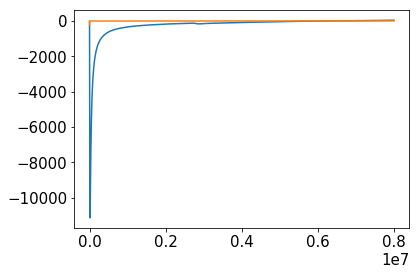

In [14]:
plt.plot(freq,imz[-1])
plt.plot(freq,imzfit)
plt.show()

In [15]:
# save results in csv file

# open CSV file for saving spectra ##########################################################
fileheaders = ['frequency'] # build list of file headers
savedata = np.copy(freq) #build list of data

for i in range(spectranum):
    fileheaders.append('Ztot_' + format(i))
    fileheaders.append('ReZ_' + format(i))
    fileheaders.append('ImZ_' + format(i))
    fileheaders.append('Phase_' + format(i))
    
    savedata = np.append(savedata, ztot[i])
    savedata = np.append(savedata, rez[i])
    savedata = np.append(savedata, imz[i])
    savedata = np.append(savedata, phase[i])
    
savedata = savedata.reshape(-1, len(pointnum))
savedata = np.transpose(savedata)

with open('EISspectra.csv', 'w') as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(fileheaders) #write headers
    for row in savedata:
        writer.writerow(row) 

# open CSV file for saving low-frequency Z values ###########################################
zheaders = ['time', 'low-freq. Z (Ohms)'] 
savedata2 = np.append(time, lowfreqz)
savedata2 = savedata2.reshape(-1, spectranum)
savedata2 = np.transpose(savedata2)

with open('EISlowFreqZ.csv', 'w') as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(zheaders) #write headers
    for row in savedata2:
        writer.writerow(row)